
## Avant de commencer le TP, 
- vérifiez que vous êtes sur un environnement GPU et python 3 : 
  
  Éxecution -> Modifier le type d'éxecution -> Type d'éxecution = python2, Accélerateur matériel = GPU

- Fichier -> Sauvegarder une copie dans mon drive

In [ ]:
# It will reload all changed modules every time before executing a new line
%load_ext autoreload
%autoreload 2



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/git/RDFIA/TME 5-6")
!ls

Mounted at /content/gdrive
 cours.pdf		        TP_5_6_CNN_Deep_Learning_Sorbonne.ipynb
 deep-learning-polytech-tp6-7   tp5-6.pdf
'~$pport TME 5-6.docx'	       '~WRL0003.tmp'
'Rapport TME 5-6.docx'	       '~WRL0140.tmp'


In [ ]:
!git clone https://github.com/cdancette/deep-learning-polytech-tp6-7.git

fatal: destination path 'deep-learning-polytech-tp6-7' already exists and is not an empty directory.


In [ ]:
cd deep-learning-polytech-tp6-7

c:\Users\Fatah\Google Drive\git\RDFIA\TME 5-6\deep-learning-polytech-tp6-7


In [ ]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tme6 import *

PRINT_INTERVAL = 200
PATH="datasets"

In [ ]:
class ConvNet(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, (5, 5), stride=1, padding=2),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),
            nn.Tanh(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(400, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, 10)
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv
        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input
        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.MNIST(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.MNIST(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss


def main(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)


=== EPOCH 1 =====

[TRAIN Batch 000/469]	Time 0.120s (0.120s)	Loss 2.3098 (2.3098)	Prec@1  14.1 ( 14.1)	Prec@5  46.9 ( 46.9)


<Figure size 432x288 with 0 Axes>

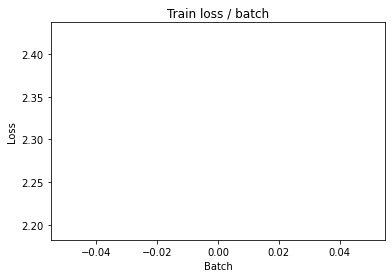

[TRAIN Batch 200/469]	Time 0.014s (0.020s)	Loss 0.3926 (1.2509)	Prec@1  92.2 ( 65.8)	Prec@5  98.4 ( 90.4)


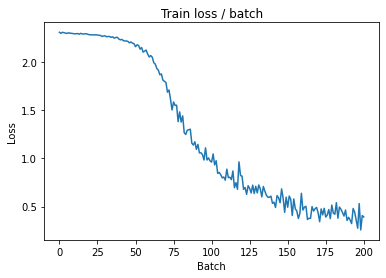

[TRAIN Batch 400/469]	Time 0.020s (0.019s)	Loss 0.2282 (0.7536)	Prec@1  93.8 ( 79.4)	Prec@5 100.0 ( 95.0)


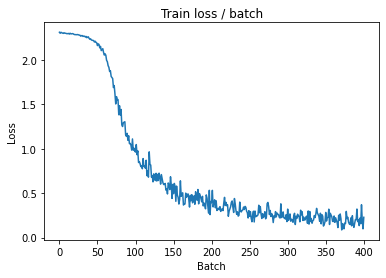


===============> Total time 9s	Avg loss 0.6664	Avg Prec@1 81.72 %	Avg Prec@5 95.73 %

[EVAL Batch 000/079]	Time 0.114s (0.114s)	Loss 0.0955 (0.0955)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.1455	Avg Prec@1 95.67 %	Avg Prec@5 99.93 %



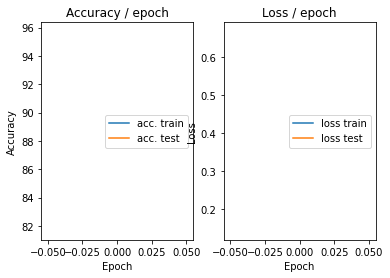

=== EPOCH 2 =====

[TRAIN Batch 000/469]	Time 0.109s (0.109s)	Loss 0.1704 (0.1704)	Prec@1  95.3 ( 95.3)	Prec@5 100.0 (100.0)


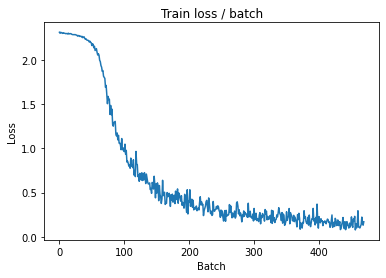

[TRAIN Batch 200/469]	Time 0.025s (0.020s)	Loss 0.1166 (0.1254)	Prec@1  96.1 ( 96.3)	Prec@5 100.0 ( 99.9)


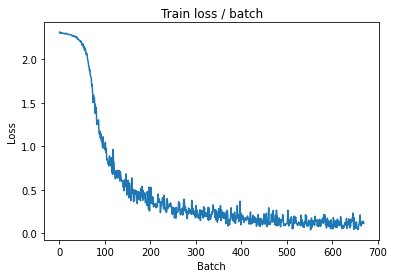

[TRAIN Batch 400/469]	Time 0.014s (0.020s)	Loss 0.0566 (0.1121)	Prec@1  98.4 ( 96.7)	Prec@5 100.0 ( 99.9)


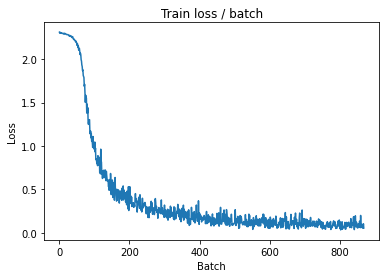


===============> Total time 9s	Avg loss 0.1090	Avg Prec@1 96.80 %	Avg Prec@5 99.92 %

[EVAL Batch 000/079]	Time 0.116s (0.116s)	Loss 0.0355 (0.0355)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0750	Avg Prec@1 97.62 %	Avg Prec@5 99.99 %



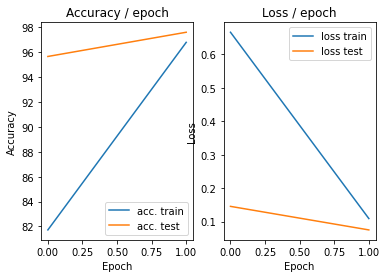

=== EPOCH 3 =====

[TRAIN Batch 000/469]	Time 0.113s (0.113s)	Loss 0.0209 (0.0209)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


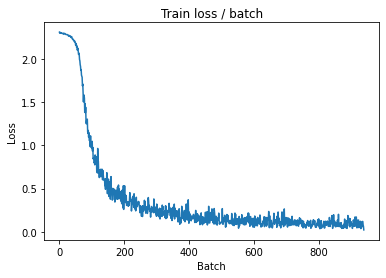

[TRAIN Batch 200/469]	Time 0.006s (0.019s)	Loss 0.0497 (0.0759)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


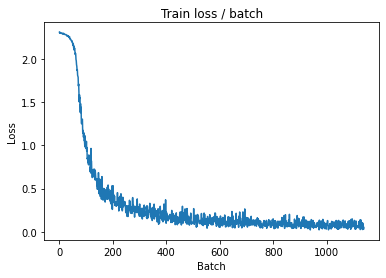

[TRAIN Batch 400/469]	Time 0.026s (0.019s)	Loss 0.0628 (0.0731)	Prec@1  97.7 ( 97.8)	Prec@5 100.0 (100.0)


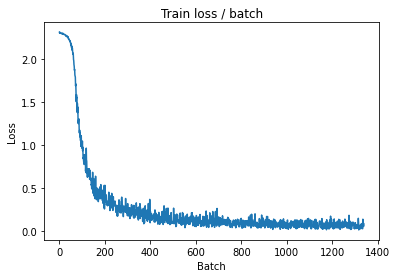


===============> Total time 9s	Avg loss 0.0740	Avg Prec@1 97.78 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.100s (0.100s)	Loss 0.0256 (0.0256)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0584	Avg Prec@1 98.16 %	Avg Prec@5 99.98 %



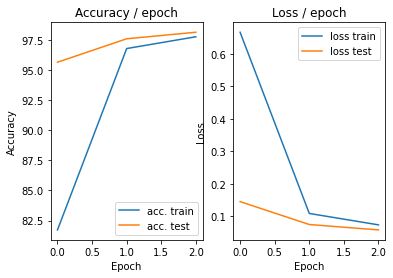

=== EPOCH 4 =====

[TRAIN Batch 000/469]	Time 0.124s (0.124s)	Loss 0.0431 (0.0431)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


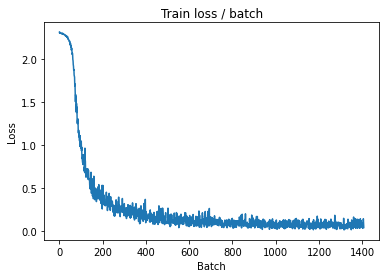

[TRAIN Batch 200/469]	Time 0.014s (0.020s)	Loss 0.0631 (0.0626)	Prec@1  98.4 ( 98.2)	Prec@5 100.0 (100.0)


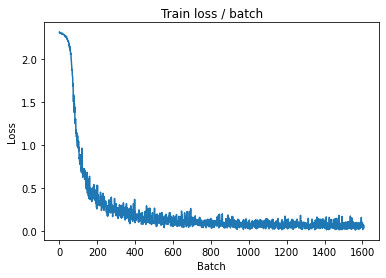

[TRAIN Batch 400/469]	Time 0.008s (0.019s)	Loss 0.1169 (0.0587)	Prec@1  96.9 ( 98.3)	Prec@5 100.0 (100.0)


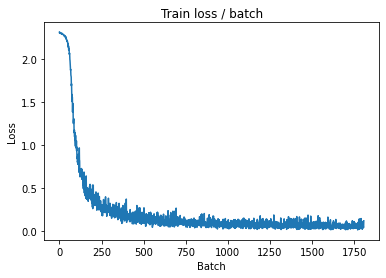


===============> Total time 9s	Avg loss 0.0585	Avg Prec@1 98.29 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.108s (0.108s)	Loss 0.0211 (0.0211)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0482	Avg Prec@1 98.47 %	Avg Prec@5 100.00 %



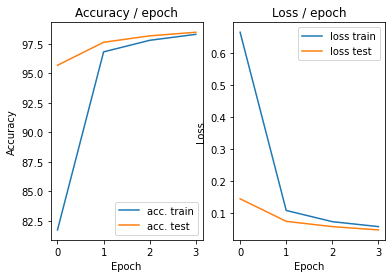

=== EPOCH 5 =====

[TRAIN Batch 000/469]	Time 0.115s (0.115s)	Loss 0.0163 (0.0163)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


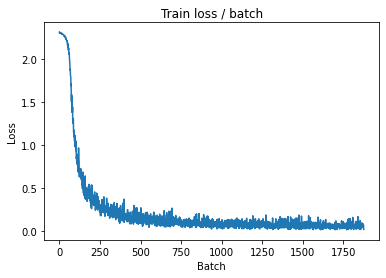

[TRAIN Batch 200/469]	Time 0.029s (0.019s)	Loss 0.0333 (0.0510)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


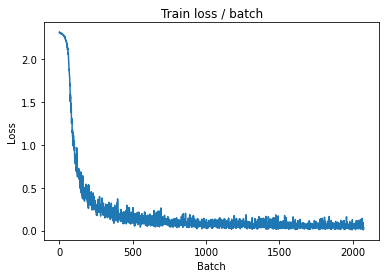

[TRAIN Batch 400/469]	Time 0.006s (0.018s)	Loss 0.0662 (0.0492)	Prec@1  99.2 ( 98.5)	Prec@5 100.0 (100.0)


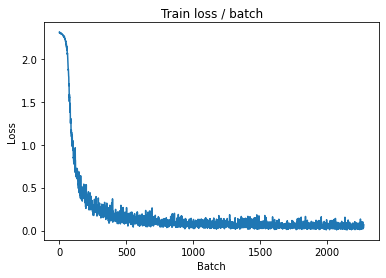


===============> Total time 8s	Avg loss 0.0494	Avg Prec@1 98.55 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.112s (0.112s)	Loss 0.0184 (0.0184)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)

===============> Total time 1s	Avg loss 0.0482	Avg Prec@1 98.39 %	Avg Prec@5 100.00 %



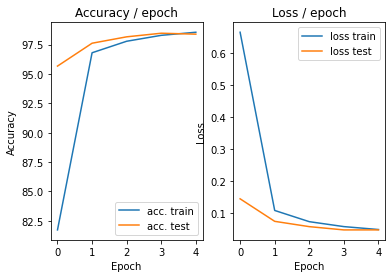

In [ ]:
main(128, 0.1, cuda=True)

### Modifiez le code pour utiliser la base CIFAR-10 et implémenter l’architecture demandée ci-dessus. (la classe est datasets.CIFAR10 ). 
### Attention à bien faire suffisament d’epoques pour que le modèle ait fini de converger.

remplacer MNIST par CIFAR10 dans dataset

In [43]:
class ConvNet2(nn.Module):
    """
    Cette classe contient la structure du réseau de neurones
    """

    def __init__(self):
        super(ConvNet2, self).__init__()
        # On défini d'abord les couches de convolution et de pooling comme un
        # groupe de couches `self.features`
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(32, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
            nn.Conv2d(64, 64, (5, 5), stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d((2, 2), stride=2, padding=0),
        )
        # On défini les couches fully connected comme un groupe de couches
        # `self.classifier`
        self.classifier = nn.Sequential(
            nn.Linear(4*4*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 10),
            # Rappel : Le softmax est inclus dans la loss, ne pas le mettre ici
        )

    # méthode appelée quand on applique le réseau à un batch d'input
    def forward(self, input):
        bsize = input.size(0) # taille du batch
        output = self.features(input) # on calcule la sortie des conv

        output = output.view(bsize, -1) # on applati les feature map 2D en un
                                        # vecteur 1D pour chaque input

        output = self.classifier(output) # on calcule la sortie des fc
        return output



def get_dataset(batch_size, cuda=False):
    """
    Cette fonction charge le dataset et effectue des transformations sur chaqu
    image (listées dans `transform=...`).
    """
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))
    val_dataset = datasets.CIFAR10(PATH, train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor()
        ]))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=cuda, num_workers=2)

    return train_loader, val_loader



def epoch(data, model, criterion, optimizer=None, cuda=False):
    """
    Fait une passe (appelée epoch en anglais) sur les données `data` avec le
    modèle `model`. Evalue `criterion` comme loss.
    Si `optimizer` est fourni, effectue une epoch d'apprentissage en utilisant
    l'optimiseur donné, sinon, effectue une epoch d'évaluation (pas de backward)
    du modèle.
    """

    # indique si le modele est en mode eval ou train (certaines couches se
    # comportent différemment en train et en eval)
    model.eval() if optimizer is None else model.train()

    # objets pour stocker les moyennes des metriques
    avg_loss = AverageMeter()
    avg_top1_acc = AverageMeter()
    avg_top5_acc = AverageMeter()
    avg_batch_time = AverageMeter()
    global loss_plot

    # on itere sur les batchs du dataset
    tic = time.time()
    for i, (input, target) in enumerate(data):

        if cuda: # si on fait du GPU, passage en CUDA
            input = input.cuda()
            target = target.cuda()

        # forward
        output = model(input)
        loss = criterion(output, target)

        # backward si on est en "train"
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calcul des metriques
        prec1, prec5 = accuracy(output, target, topk=(1, 5))
        batch_time = time.time() - tic
        tic = time.time()

        # mise a jour des moyennes
        avg_loss.update(loss.item())
        avg_top1_acc.update(prec1.item())
        avg_top5_acc.update(prec5.item())
        avg_batch_time.update(batch_time)
        if optimizer:
            loss_plot.update(avg_loss.val)
        # affichage des infos
        if i % PRINT_INTERVAL == 0:
            print('[{0:s} Batch {1:03d}/{2:03d}]\t'
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:5.1f} ({top1.avg:5.1f})\t'
                  'Prec@5 {top5.val:5.1f} ({top5.avg:5.1f})'.format(
                   "EVAL" if optimizer is None else "TRAIN", i, len(data), batch_time=avg_batch_time, loss=avg_loss,
                   top1=avg_top1_acc, top5=avg_top5_acc))
            if optimizer:
                loss_plot.plot()

    # Affichage des infos sur l'epoch
    print('\n===============> Total time {batch_time:d}s\t'
          'Avg loss {loss.avg:.4f}\t'
          'Avg Prec@1 {top1.avg:5.2f} %\t'
          'Avg Prec@5 {top5.avg:5.2f} %\n'.format(
           batch_time=int(avg_batch_time.sum), loss=avg_loss,
           top1=avg_top1_acc, top5=avg_top5_acc))

    return avg_top1_acc, avg_top5_acc, avg_loss

def main2(batch_size=128, lr=0.1, epochs=5, cuda=False):

    # ex de params :
    #   {"batch_size": 128, "epochs": 5, "lr": 0.1}
    
    # define model, loss, optim
    model = ConvNet2()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)

    if cuda: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()
        criterion = criterion.cuda()

    # On récupère les données
    train, test = get_dataset(batch_size, cuda)

    # init plots
    plot = AccLossPlot()
    global loss_plot
    loss_plot = TrainLossPlot()

    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        top1_acc, avg_top5_acc, loss = epoch(train, model, criterion, optimizer, cuda)
        # Phase d'evaluation
        top1_acc_test, top5_acc_test, loss_test = epoch(test, model, criterion, cuda=cuda)
        # plot
        plot.update(loss.avg, loss_test.avg, top1_acc.avg, top1_acc_test.avg)

Files already downloaded and verified
Files already downloaded and verified
=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.143s (0.143s)	Loss 2.3026 (2.3026)	Prec@1  12.5 ( 12.5)	Prec@5  47.7 ( 47.7)


<Figure size 432x288 with 0 Axes>

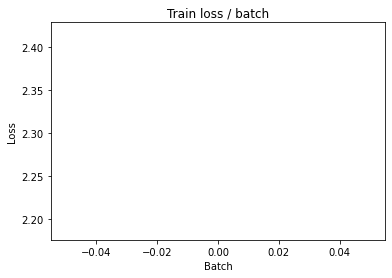

[TRAIN Batch 200/391]	Time 0.028s (0.025s)	Loss 2.3285 (2.2545)	Prec@1  12.5 ( 14.9)	Prec@5  63.3 ( 60.0)


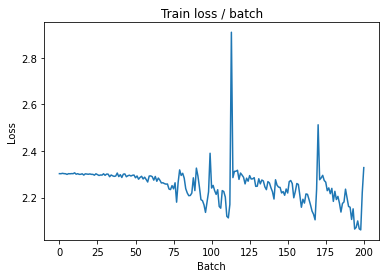


===============> Total time 9s	Avg loss 2.1530	Avg Prec@1 20.16 %	Avg Prec@5 67.89 %

[EVAL Batch 000/079]	Time 0.134s (0.134s)	Loss 1.9637 (1.9637)	Prec@1  34.4 ( 34.4)	Prec@5  85.2 ( 85.2)

===============> Total time 1s	Avg loss 2.0074	Avg Prec@1 29.18 %	Avg Prec@5 79.95 %



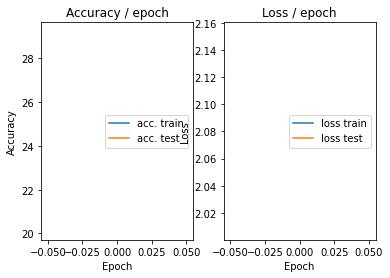

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.141s (0.141s)	Loss 2.0053 (2.0053)	Prec@1  24.2 ( 24.2)	Prec@5  79.7 ( 79.7)


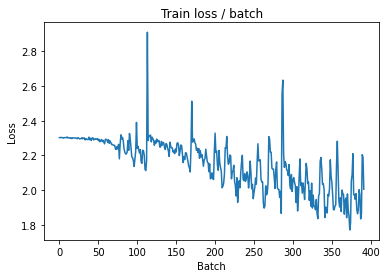

[TRAIN Batch 200/391]	Time 0.012s (0.025s)	Loss 1.6519 (1.8638)	Prec@1  38.3 ( 32.8)	Prec@5  91.4 ( 83.3)


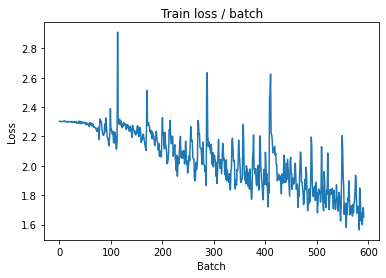


===============> Total time 9s	Avg loss 1.7491	Avg Prec@1 36.85 %	Avg Prec@5 86.16 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.4536 (1.4536)	Prec@1  50.0 ( 50.0)	Prec@5  91.4 ( 91.4)

===============> Total time 1s	Avg loss 1.5526	Avg Prec@1 44.19 %	Avg Prec@5 90.68 %



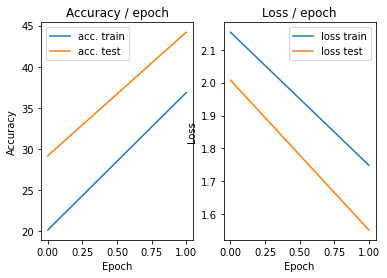

=== EPOCH 3 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 1.4582 (1.4582)	Prec@1  46.9 ( 46.9)	Prec@5  93.8 ( 93.8)


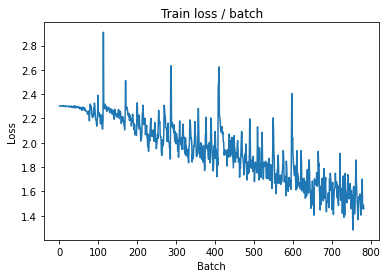

[TRAIN Batch 200/391]	Time 0.024s (0.025s)	Loss 1.2107 (1.4889)	Prec@1  60.2 ( 46.8)	Prec@5  96.1 ( 91.7)


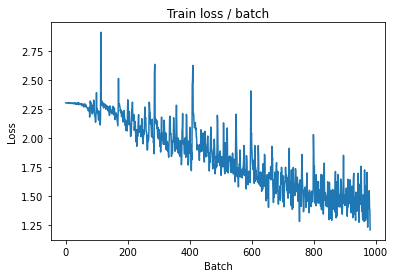


===============> Total time 9s	Avg loss 1.4423	Avg Prec@1 48.38 %	Avg Prec@5 92.36 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.2198 (1.2198)	Prec@1  62.5 ( 62.5)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.3597	Avg Prec@1 50.78 %	Avg Prec@5 93.50 %



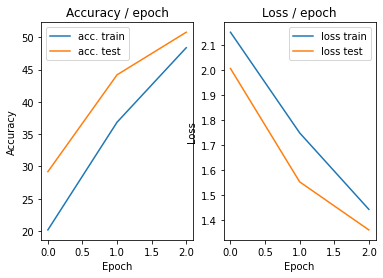

=== EPOCH 4 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 1.3503 (1.3503)	Prec@1  54.7 ( 54.7)	Prec@5  89.8 ( 89.8)


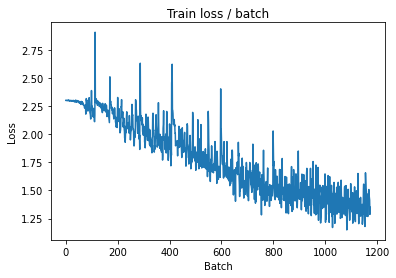

[TRAIN Batch 200/391]	Time 0.022s (0.025s)	Loss 1.1734 (1.2868)	Prec@1  57.0 ( 54.3)	Prec@5  96.1 ( 94.1)


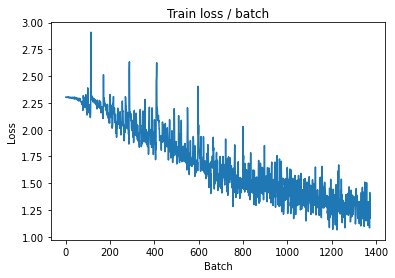


===============> Total time 9s	Avg loss 1.2660	Avg Prec@1 54.84 %	Avg Prec@5 94.49 %

[EVAL Batch 000/079]	Time 0.142s (0.142s)	Loss 1.1894 (1.1894)	Prec@1  52.3 ( 52.3)	Prec@5  99.2 ( 99.2)

===============> Total time 1s	Avg loss 1.3306	Avg Prec@1 52.36 %	Avg Prec@5 93.55 %



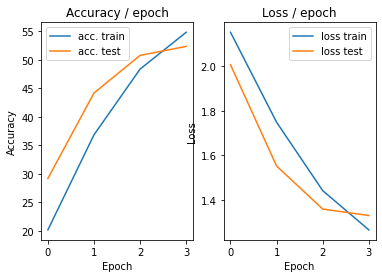

=== EPOCH 5 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 1.2518 (1.2518)	Prec@1  57.8 ( 57.8)	Prec@5  96.1 ( 96.1)


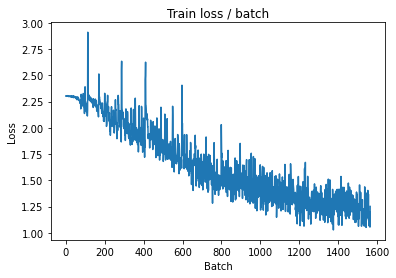

[TRAIN Batch 200/391]	Time 0.026s (0.025s)	Loss 1.0029 (1.1630)	Prec@1  70.3 ( 58.7)	Prec@5  95.3 ( 95.5)


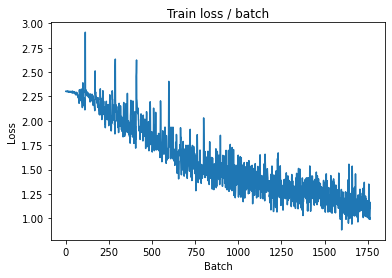


===============> Total time 9s	Avg loss 1.1347	Avg Prec@1 59.94 %	Avg Prec@5 95.70 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 0.9569 (0.9569)	Prec@1  64.1 ( 64.1)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.1134	Avg Prec@1 60.12 %	Avg Prec@5 95.95 %



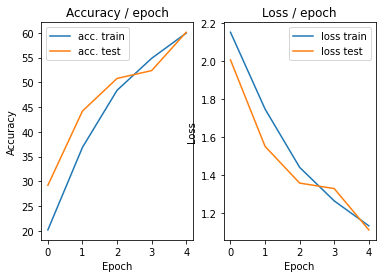

=== EPOCH 6 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.9913 (0.9913)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)


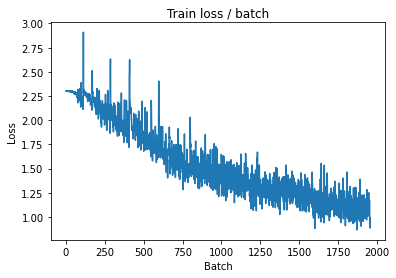

[TRAIN Batch 200/391]	Time 0.015s (0.025s)	Loss 1.0410 (1.0278)	Prec@1  60.9 ( 64.0)	Prec@5  98.4 ( 96.5)


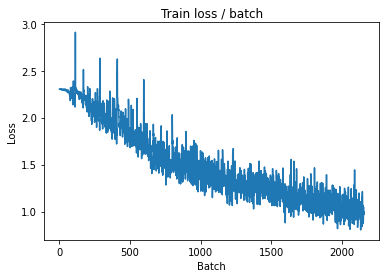


===============> Total time 9s	Avg loss 1.0127	Avg Prec@1 64.47 %	Avg Prec@5 96.60 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.0035 (1.0035)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1283	Avg Prec@1 59.78 %	Avg Prec@5 95.67 %



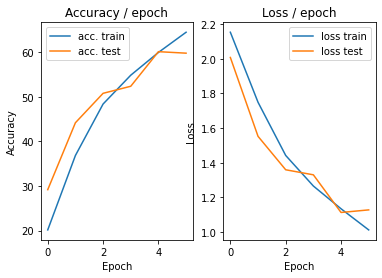

=== EPOCH 7 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 1.0641 (1.0641)	Prec@1  61.7 ( 61.7)	Prec@5  96.1 ( 96.1)


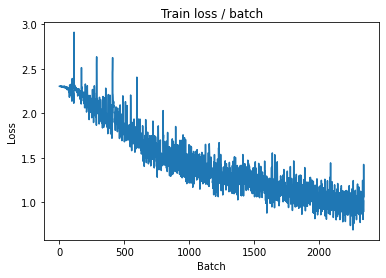

[TRAIN Batch 200/391]	Time 0.025s (0.025s)	Loss 0.9316 (0.9079)	Prec@1  71.1 ( 68.3)	Prec@5  96.1 ( 97.5)


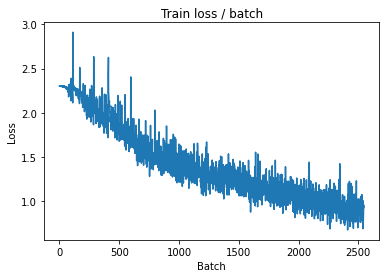


===============> Total time 9s	Avg loss 0.8995	Avg Prec@1 68.47 %	Avg Prec@5 97.56 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 0.9644 (0.9644)	Prec@1  67.2 ( 67.2)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.0335	Avg Prec@1 63.82 %	Avg Prec@5 96.36 %



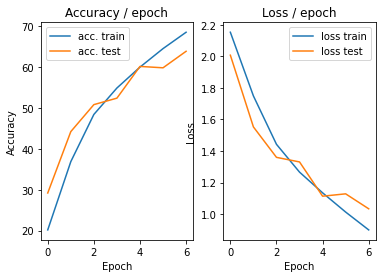

=== EPOCH 8 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.8166 (0.8166)	Prec@1  72.7 ( 72.7)	Prec@5  99.2 ( 99.2)


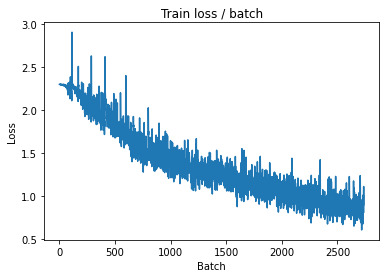

[TRAIN Batch 200/391]	Time 0.017s (0.024s)	Loss 0.6804 (0.7950)	Prec@1  76.6 ( 72.2)	Prec@5  99.2 ( 98.0)


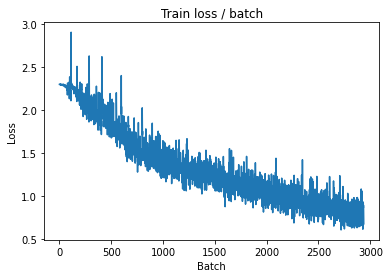


===============> Total time 9s	Avg loss 0.7936	Avg Prec@1 72.26 %	Avg Prec@5 98.07 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 1.0387 (1.0387)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0580	Avg Prec@1 63.22 %	Avg Prec@5 96.43 %



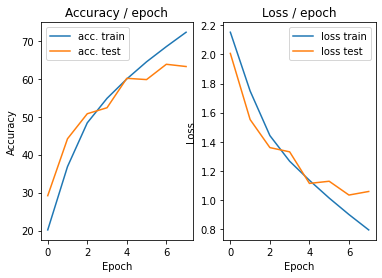

=== EPOCH 9 =====

[TRAIN Batch 000/391]	Time 0.156s (0.156s)	Loss 0.8433 (0.8433)	Prec@1  71.9 ( 71.9)	Prec@5  98.4 ( 98.4)


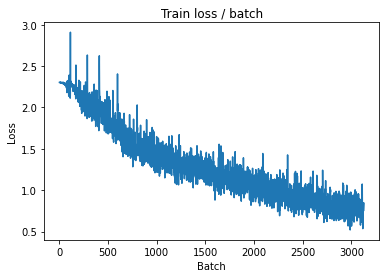

[TRAIN Batch 200/391]	Time 0.033s (0.025s)	Loss 0.8301 (0.6872)	Prec@1  74.2 ( 75.9)	Prec@5  97.7 ( 98.6)


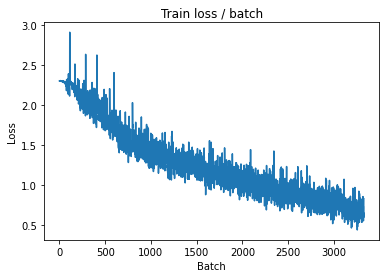


===============> Total time 9s	Avg loss 0.6958	Avg Prec@1 75.63 %	Avg Prec@5 98.58 %

[EVAL Batch 000/079]	Time 0.130s (0.130s)	Loss 1.0001 (1.0001)	Prec@1  67.2 ( 67.2)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 0.9692	Avg Prec@1 67.37 %	Avg Prec@5 97.03 %



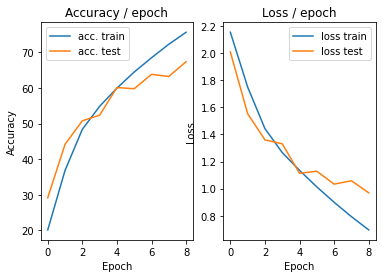

=== EPOCH 10 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.6280 (0.6280)	Prec@1  79.7 ( 79.7)	Prec@5  99.2 ( 99.2)


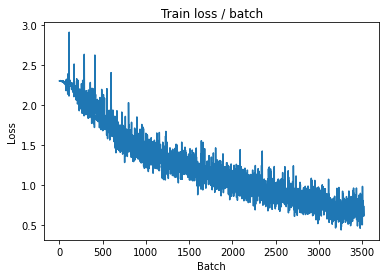

[TRAIN Batch 200/391]	Time 0.026s (0.026s)	Loss 0.6515 (0.6026)	Prec@1  76.6 ( 79.0)	Prec@5  97.7 ( 99.0)


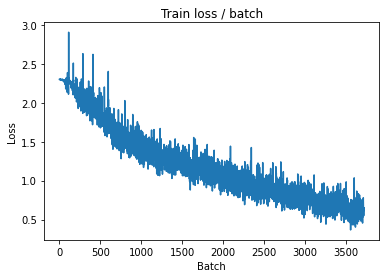


===============> Total time 9s	Avg loss 0.6051	Avg Prec@1 78.88 %	Avg Prec@5 98.98 %

[EVAL Batch 000/079]	Time 0.143s (0.143s)	Loss 0.9334 (0.9334)	Prec@1  71.9 ( 71.9)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 0.9526	Avg Prec@1 68.12 %	Avg Prec@5 96.96 %



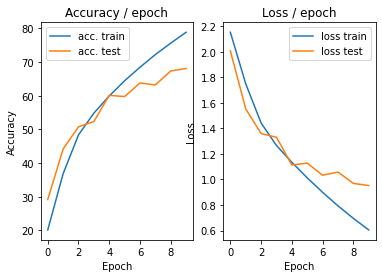

=== EPOCH 11 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.5188 (0.5188)	Prec@1  81.2 ( 81.2)	Prec@5  98.4 ( 98.4)


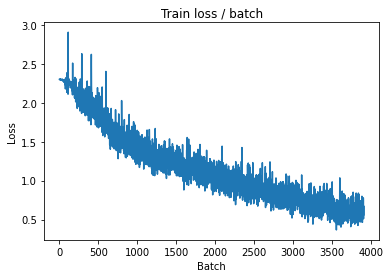

[TRAIN Batch 200/391]	Time 0.015s (0.024s)	Loss 0.4752 (0.4885)	Prec@1  82.8 ( 82.9)	Prec@5 100.0 ( 99.4)


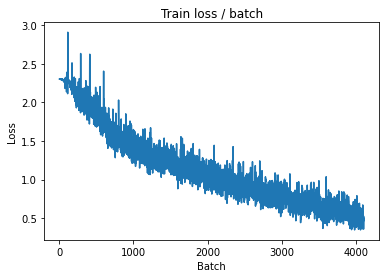


===============> Total time 9s	Avg loss 0.5082	Avg Prec@1 82.20 %	Avg Prec@5 99.34 %

[EVAL Batch 000/079]	Time 0.149s (0.149s)	Loss 0.9451 (0.9451)	Prec@1  69.5 ( 69.5)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9376	Avg Prec@1 70.09 %	Avg Prec@5 97.38 %



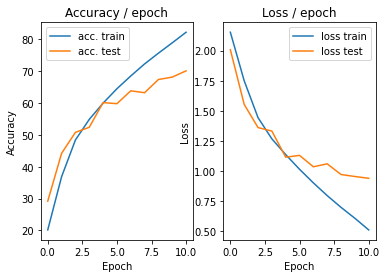

=== EPOCH 12 =====

[TRAIN Batch 000/391]	Time 0.142s (0.142s)	Loss 0.3385 (0.3385)	Prec@1  86.7 ( 86.7)	Prec@5 100.0 (100.0)


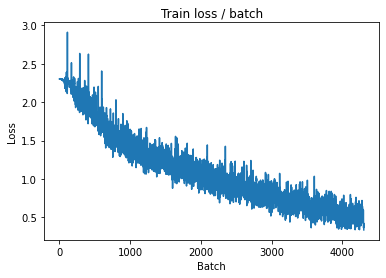

[TRAIN Batch 200/391]	Time 0.030s (0.025s)	Loss 0.3376 (0.4155)	Prec@1  85.9 ( 85.4)	Prec@5  99.2 ( 99.7)


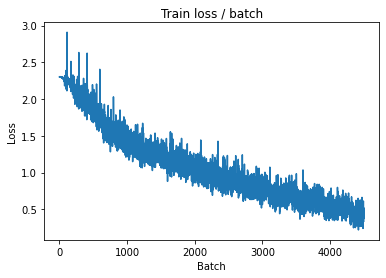


===============> Total time 9s	Avg loss 0.4239	Avg Prec@1 85.17 %	Avg Prec@5 99.63 %

[EVAL Batch 000/079]	Time 0.124s (0.124s)	Loss 1.1023 (1.1023)	Prec@1  64.1 ( 64.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 0.9971	Avg Prec@1 69.51 %	Avg Prec@5 97.17 %



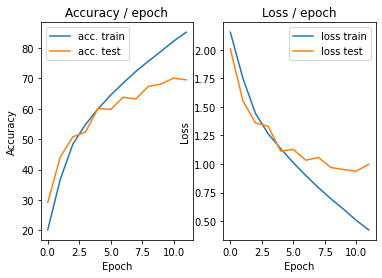

=== EPOCH 13 =====

[TRAIN Batch 000/391]	Time 0.140s (0.140s)	Loss 0.2696 (0.2696)	Prec@1  90.6 ( 90.6)	Prec@5 100.0 (100.0)


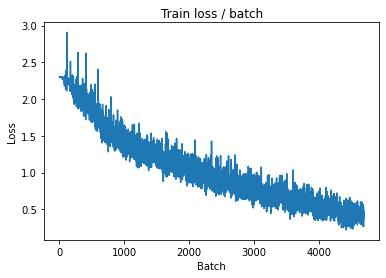

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.2395 (0.3047)	Prec@1  91.4 ( 89.5)	Prec@5 100.0 ( 99.8)


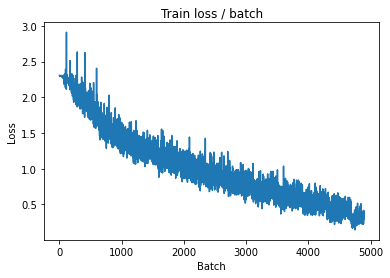


===============> Total time 9s	Avg loss 0.3250	Avg Prec@1 88.71 %	Avg Prec@5 99.82 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 1.1027 (1.1027)	Prec@1  64.8 ( 64.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.0790	Avg Prec@1 69.88 %	Avg Prec@5 97.36 %



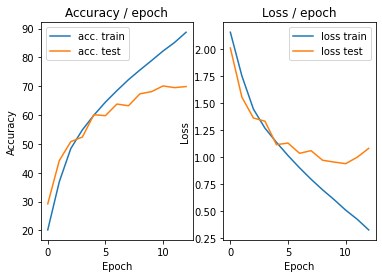

=== EPOCH 14 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.2328 (0.2328)	Prec@1  92.2 ( 92.2)	Prec@5 100.0 (100.0)


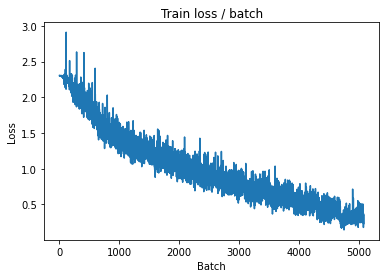

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.3681 (0.2187)	Prec@1  85.9 ( 92.7)	Prec@5 100.0 ( 99.9)


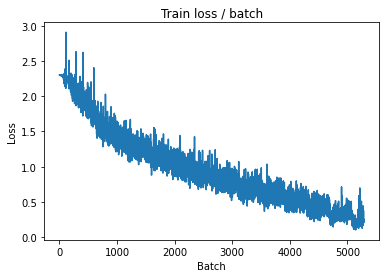


===============> Total time 9s	Avg loss 0.2404	Avg Prec@1 91.85 %	Avg Prec@5 99.88 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 1.1346 (1.1346)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.1401	Avg Prec@1 68.85 %	Avg Prec@5 97.23 %



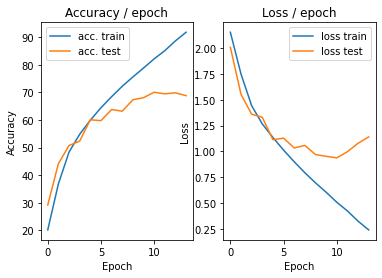

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.134s (0.134s)	Loss 0.1833 (0.1833)	Prec@1  94.5 ( 94.5)	Prec@5 100.0 (100.0)


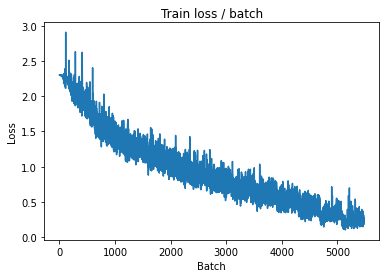

[TRAIN Batch 200/391]	Time 0.035s (0.025s)	Loss 0.1020 (0.1464)	Prec@1  99.2 ( 95.1)	Prec@5 100.0 (100.0)


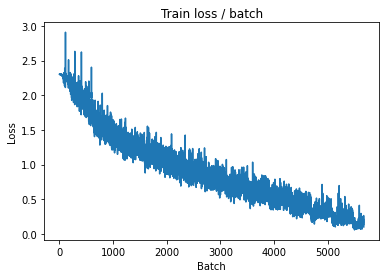


===============> Total time 9s	Avg loss 0.1758	Avg Prec@1 93.95 %	Avg Prec@5 99.96 %

[EVAL Batch 000/079]	Time 0.139s (0.139s)	Loss 1.3419 (1.3419)	Prec@1  70.3 ( 70.3)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.3215	Avg Prec@1 68.55 %	Avg Prec@5 96.89 %



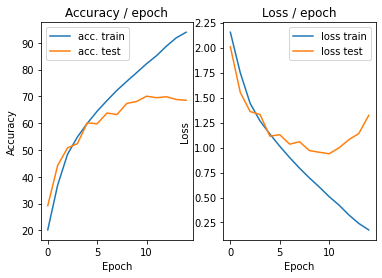

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.1081 (0.1081)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


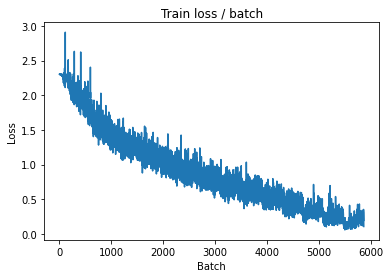

[TRAIN Batch 200/391]	Time 0.023s (0.025s)	Loss 0.1126 (0.1017)	Prec@1  94.5 ( 96.8)	Prec@5 100.0 (100.0)


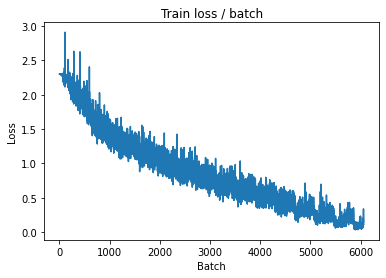


===============> Total time 9s	Avg loss 0.1171	Avg Prec@1 96.14 %	Avg Prec@5 99.99 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.6606 (1.6606)	Prec@1  67.2 ( 67.2)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.5820	Avg Prec@1 67.13 %	Avg Prec@5 96.58 %



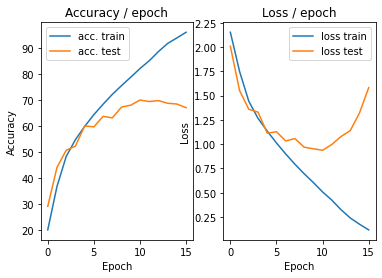

=== EPOCH 17 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 0.2817 (0.2817)	Prec@1  89.1 ( 89.1)	Prec@5 100.0 (100.0)


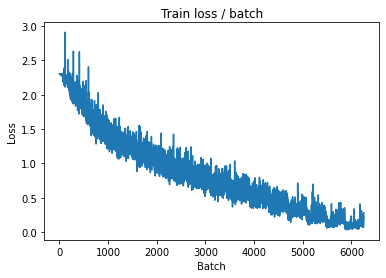

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.1127 (0.0765)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


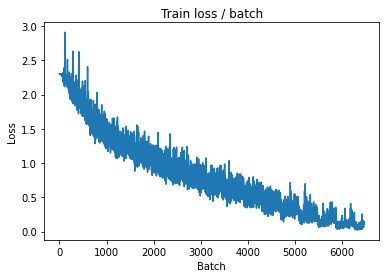


===============> Total time 9s	Avg loss 0.0955	Avg Prec@1 96.95 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.121s (0.121s)	Loss 1.6423 (1.6423)	Prec@1  68.8 ( 68.8)	Prec@5  95.3 ( 95.3)

===============> Total time 1s	Avg loss 1.4135	Avg Prec@1 70.39 %	Avg Prec@5 97.06 %



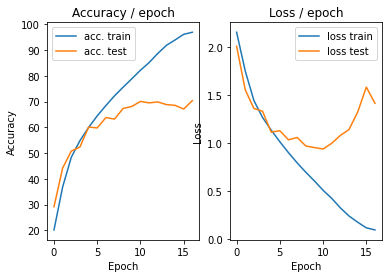

=== EPOCH 18 =====

[TRAIN Batch 000/391]	Time 0.137s (0.137s)	Loss 0.0747 (0.0747)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


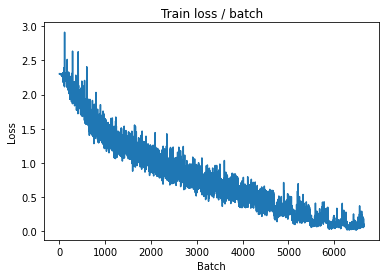

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0715 (0.0625)	Prec@1  98.4 ( 98.2)	Prec@5 100.0 (100.0)


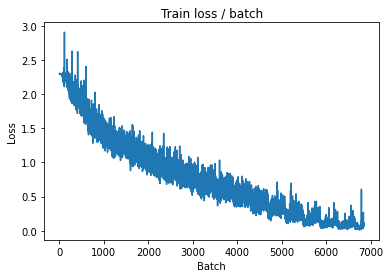


===============> Total time 9s	Avg loss 0.0720	Avg Prec@1 97.79 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.0775 (2.0775)	Prec@1  66.4 ( 66.4)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.6136	Avg Prec@1 68.33 %	Avg Prec@5 96.96 %



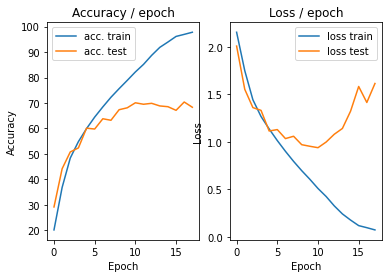

=== EPOCH 19 =====

[TRAIN Batch 000/391]	Time 0.153s (0.153s)	Loss 0.0735 (0.0735)	Prec@1  96.9 ( 96.9)	Prec@5 100.0 (100.0)


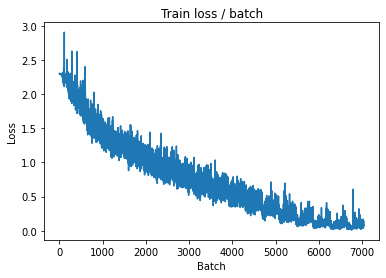

[TRAIN Batch 200/391]	Time 0.034s (0.025s)	Loss 0.0356 (0.0428)	Prec@1  99.2 ( 98.7)	Prec@5 100.0 (100.0)


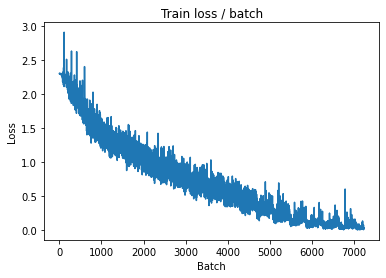


===============> Total time 9s	Avg loss 0.0507	Avg Prec@1 98.41 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.129s (0.129s)	Loss 1.9186 (1.9186)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.6342	Avg Prec@1 70.27 %	Avg Prec@5 97.01 %



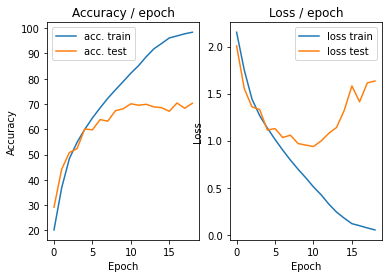

=== EPOCH 20 =====

[TRAIN Batch 000/391]	Time 0.148s (0.148s)	Loss 0.0349 (0.0349)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


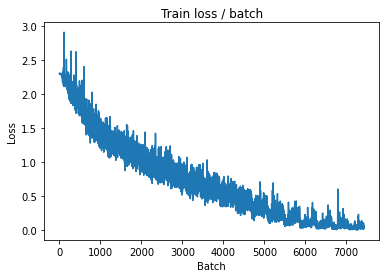

[TRAIN Batch 200/391]	Time 0.019s (0.025s)	Loss 0.0625 (0.0313)	Prec@1  97.7 ( 99.1)	Prec@5 100.0 (100.0)


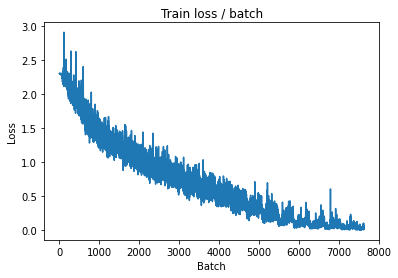


===============> Total time 9s	Avg loss 0.0334	Avg Prec@1 99.01 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.138s (0.138s)	Loss 2.2035 (2.2035)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.7610	Avg Prec@1 70.45 %	Avg Prec@5 97.32 %



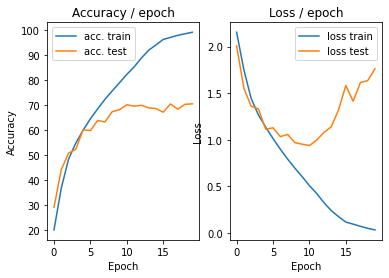

=== EPOCH 21 =====

[TRAIN Batch 000/391]	Time 0.152s (0.152s)	Loss 0.0523 (0.0523)	Prec@1  98.4 ( 98.4)	Prec@5 100.0 (100.0)


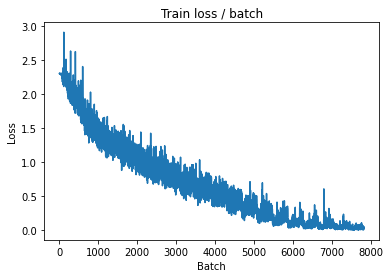

[TRAIN Batch 200/391]	Time 0.020s (0.026s)	Loss 0.0686 (0.0182)	Prec@1  98.4 ( 99.6)	Prec@5 100.0 (100.0)


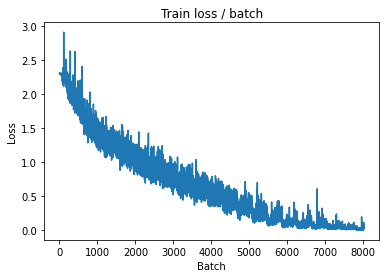


===============> Total time 9s	Avg loss 0.0232	Avg Prec@1 99.38 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 1.9284 (1.9284)	Prec@1  71.1 ( 71.1)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.9217	Avg Prec@1 69.20 %	Avg Prec@5 97.17 %



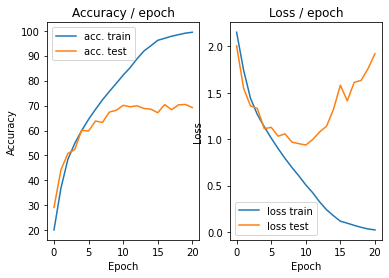

=== EPOCH 22 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.0357 (0.0357)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


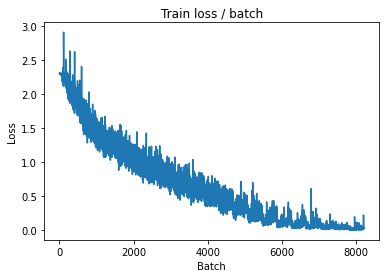

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0455 (0.0200)	Prec@1  99.2 ( 99.4)	Prec@5 100.0 (100.0)


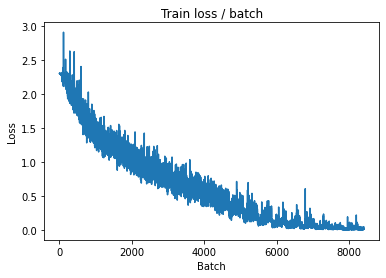


===============> Total time 9s	Avg loss 0.0334	Avg Prec@1 98.97 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.132s (0.132s)	Loss 2.0474 (2.0474)	Prec@1  72.7 ( 72.7)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0602	Avg Prec@1 68.50 %	Avg Prec@5 96.28 %



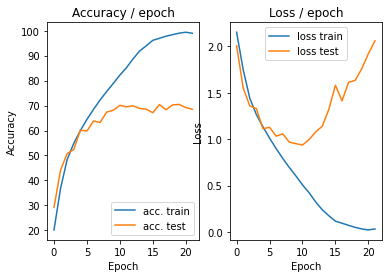

=== EPOCH 23 =====

[TRAIN Batch 000/391]	Time 0.139s (0.139s)	Loss 0.1017 (0.1017)	Prec@1  97.7 ( 97.7)	Prec@5 100.0 (100.0)


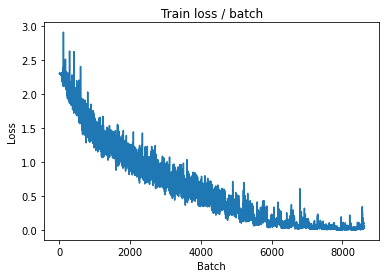

[TRAIN Batch 200/391]	Time 0.008s (0.024s)	Loss 0.0147 (0.0361)	Prec@1  99.2 ( 98.8)	Prec@5 100.0 (100.0)


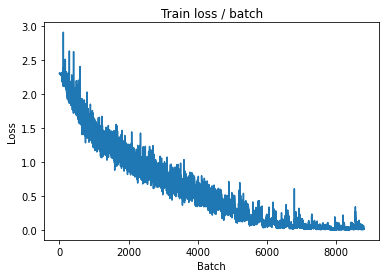


===============> Total time 9s	Avg loss 0.0295	Avg Prec@1 99.09 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.126s (0.126s)	Loss 1.9111 (1.9111)	Prec@1  71.9 ( 71.9)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 1.9853	Avg Prec@1 70.53 %	Avg Prec@5 97.15 %



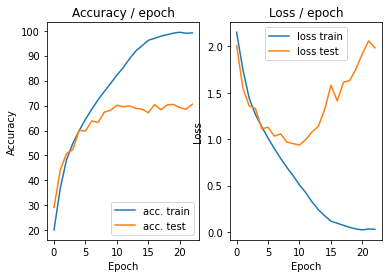

=== EPOCH 24 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.0061 (0.0061)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


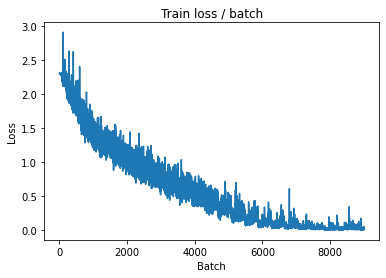

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0345 (0.0268)	Prec@1  98.4 ( 99.2)	Prec@5 100.0 (100.0)


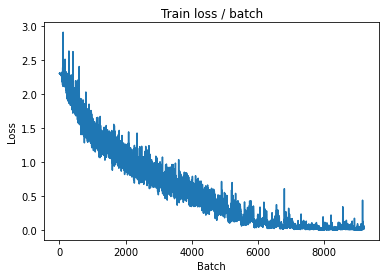


===============> Total time 9s	Avg loss 0.0657	Avg Prec@1 98.08 %	Avg Prec@5 99.98 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 1.4948 (1.4948)	Prec@1  73.4 ( 73.4)	Prec@5  96.1 ( 96.1)

===============> Total time 1s	Avg loss 1.5862	Avg Prec@1 69.44 %	Avg Prec@5 96.56 %



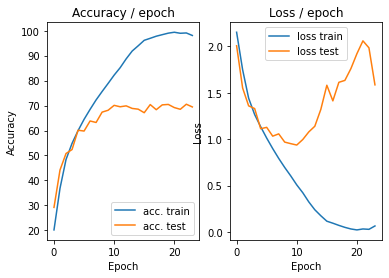

=== EPOCH 25 =====

[TRAIN Batch 000/391]	Time 0.160s (0.160s)	Loss 0.0271 (0.0271)	Prec@1  99.2 ( 99.2)	Prec@5 100.0 (100.0)


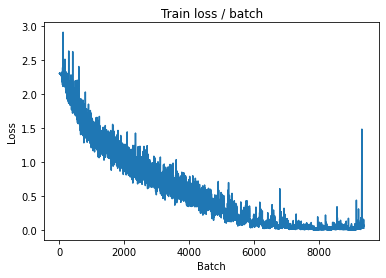

[TRAIN Batch 200/391]	Time 0.014s (0.025s)	Loss 0.0202 (0.0253)	Prec@1  99.2 ( 99.3)	Prec@5 100.0 (100.0)


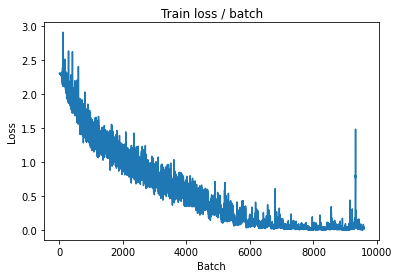


===============> Total time 9s	Avg loss 0.0228	Avg Prec@1 99.36 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.137s (0.137s)	Loss 2.0986 (2.0986)	Prec@1  69.5 ( 69.5)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 1.9542	Avg Prec@1 71.15 %	Avg Prec@5 97.20 %



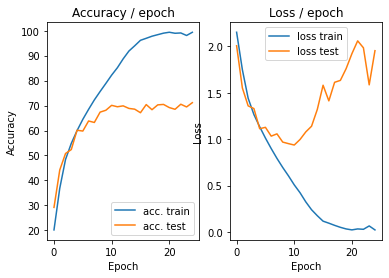

=== EPOCH 26 =====

[TRAIN Batch 000/391]	Time 0.150s (0.150s)	Loss 0.0096 (0.0096)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


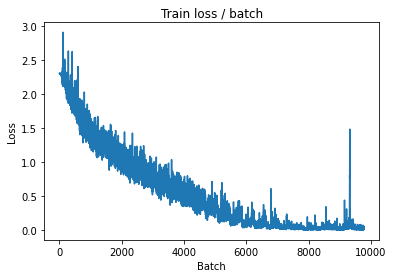

[TRAIN Batch 200/391]	Time 0.012s (0.025s)	Loss 0.0034 (0.0085)	Prec@1 100.0 ( 99.8)	Prec@5 100.0 (100.0)


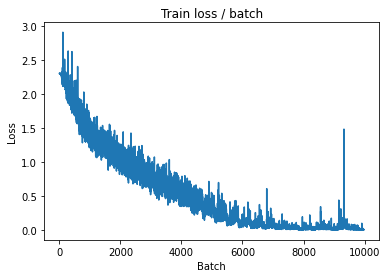


===============> Total time 9s	Avg loss 0.0071	Avg Prec@1 99.85 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.136s (0.136s)	Loss 2.0978 (2.0978)	Prec@1  70.3 ( 70.3)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0721	Avg Prec@1 70.34 %	Avg Prec@5 96.99 %



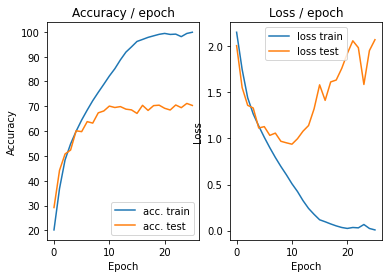

=== EPOCH 27 =====

[TRAIN Batch 000/391]	Time 0.151s (0.151s)	Loss 0.0048 (0.0048)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


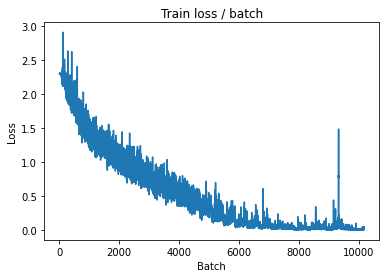

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0026 (0.0129)	Prec@1 100.0 ( 99.7)	Prec@5 100.0 (100.0)


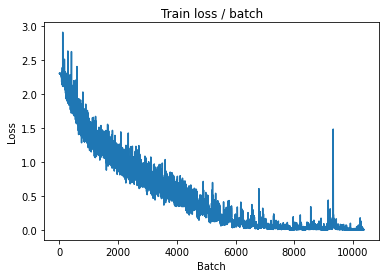


===============> Total time 9s	Avg loss 0.0095	Avg Prec@1 99.77 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.141s (0.141s)	Loss 2.1956 (2.1956)	Prec@1  73.4 ( 73.4)	Prec@5  96.9 ( 96.9)

===============> Total time 1s	Avg loss 2.0061	Avg Prec@1 71.86 %	Avg Prec@5 97.25 %



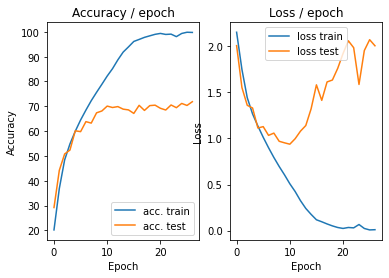

=== EPOCH 28 =====

[TRAIN Batch 000/391]	Time 0.158s (0.158s)	Loss 0.0015 (0.0015)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


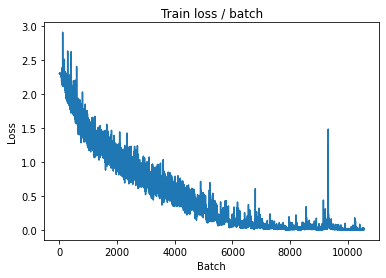

[TRAIN Batch 200/391]	Time 0.022s (0.025s)	Loss 0.0017 (0.0027)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


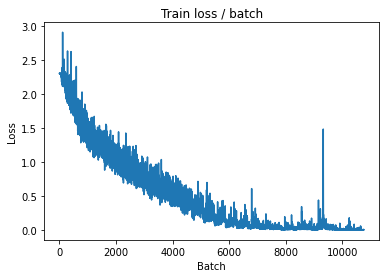


===============> Total time 9s	Avg loss 0.0023	Avg Prec@1 99.97 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.135s (0.135s)	Loss 2.1724 (2.1724)	Prec@1  70.3 ( 70.3)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.0566	Avg Prec@1 71.82 %	Avg Prec@5 97.33 %



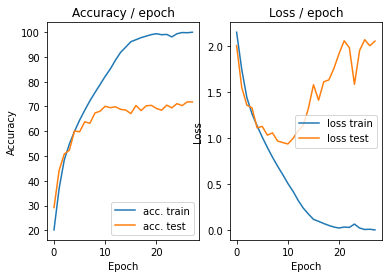

=== EPOCH 29 =====

[TRAIN Batch 000/391]	Time 0.145s (0.145s)	Loss 0.0005 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


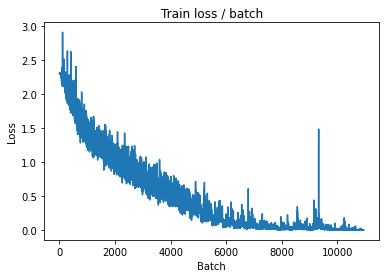

[TRAIN Batch 200/391]	Time 0.027s (0.025s)	Loss 0.0003 (0.0005)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


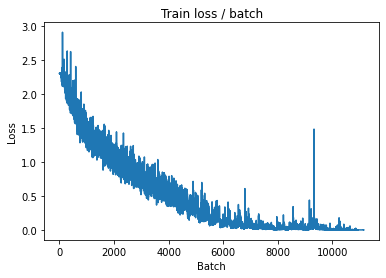


===============> Total time 9s	Avg loss 0.0005	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.2685 (2.2685)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1127	Avg Prec@1 71.80 %	Avg Prec@5 97.43 %



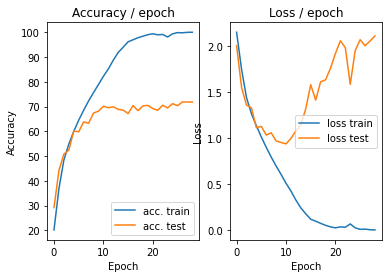

=== EPOCH 30 =====

[TRAIN Batch 000/391]	Time 0.147s (0.147s)	Loss 0.0004 (0.0004)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


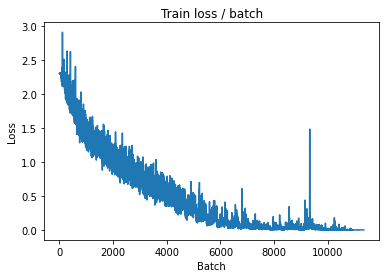

[TRAIN Batch 200/391]	Time 0.021s (0.025s)	Loss 0.0003 (0.0003)	Prec@1 100.0 (100.0)	Prec@5 100.0 (100.0)


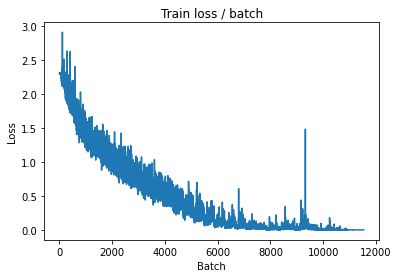


===============> Total time 9s	Avg loss 0.0003	Avg Prec@1 100.00 %	Avg Prec@5 100.00 %

[EVAL Batch 000/079]	Time 0.131s (0.131s)	Loss 2.2967 (2.2967)	Prec@1  71.1 ( 71.1)	Prec@5  97.7 ( 97.7)

===============> Total time 1s	Avg loss 2.1530	Avg Prec@1 71.95 %	Avg Prec@5 97.41 %



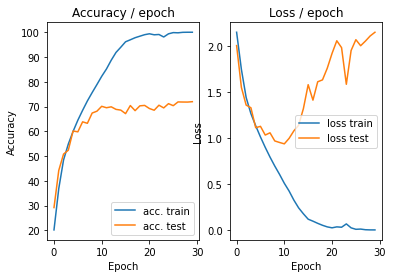

In [45]:
main2(128, 0.1, epochs=30 ,cuda=True)